In [1]:
import requests
import pandas as pd
import json


#Iphone
url='https://www.pricerunner.se/se/api/search-compare-gateway/public/pricehistory/product/3331926709/SE/DAY?merchantId=&selectedInterval=INFINITE_DAYS&filter=NATIONAL'
#robotgräsklippare
#url='https://www.pricerunner.se/se/api/search-compare-gateway/public/pricehistory/product/3201052701/SE/DAY?merchantId=&selectedInterval=INFINITE_DAYS&filter=NATIONAL'

# Fetch price data from Pricerunner
response = requests.get(url).content

# Parse the JSON response
data = json.loads(response)

# Convert the 'history' section to a Pandas DataFrame
price_history = pd.DataFrame(data['history'])

# Display the DataFrame
print(price_history)

    merchantId  merchantName                           offerId  \
0          108          Elon  f0a9ddd2d5cb5f6c5c8ed254c670bf8d   
1          108          Elon  82d7ebf972cd3d8c5c8a52e9a3c5ebc3   
2          108          Elon  82d7ebf972cd3d8c5c8a52e9a3c5ebc3   
3        86787         POWER  f524d802a7fa404d3d7e0fa498754db4   
4        86787         POWER  f524d802a7fa404d3d7e0fa498754db4   
..         ...           ...                               ...   
187     282593         mfive  d88d11ba3a93aab117adcc4b8e3ae188   
188     282593         mfive  d88d11ba3a93aab117adcc4b8e3ae188   
189     282593         mfive  727c41d823cfe1862eb25d97fcaf5d93   
190      95107  ComputerSalg  6512c50ac36a4c7f3962204b7ceceb40   
191     282593         mfive  727c41d823cfe1862eb25d97fcaf5d93   

                         timestamp timestampEpoch    price  
0    2024-09-10T00:00:00.000+02:00  1725995603380  17490.0  
1    2024-09-11T00:00:00.000+02:00  1726047355230  17490.0  
2    2024-09-12T00:00:00

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Convert timestamp to datetime and sort
#price_history['timestamp'] = pd.to_datetime(price_history['timestamp'])
price_history['timestamp'] = pd.to_datetime(price_history['timestamp'], utc=True)

price_history = price_history.sort_values(by='timestamp')

# Create a target column: 1 if price increased, 0 if decreased
price_history['price_change'] = (price_history['price'].diff() > 0).astype(int)

# Drop the first row with NaN in price_change
price_history = price_history.dropna()

# Feature engineering: Add lag features
price_history['price_lag1'] = price_history['price'].shift(1)
price_history['price_lag2'] = price_history['price'].shift(2)
price_history = price_history.dropna()

# Select features and target
features = ['price_lag1', 'price_lag2']
target = 'price_change'

X = price_history[features]
y = price_history[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# Predict the next month's trend
latest_data = price_history.iloc[-2:][features]
next_month_prediction = model.predict(latest_data)
print("Next month's price trend prediction:", next_month_prediction)

# Accuracy: 0.7222222222222222
# Next month's price trend prediction: [0 1]

Accuracy: 0.8157894736842105
Next month's price trend prediction: [0 1]


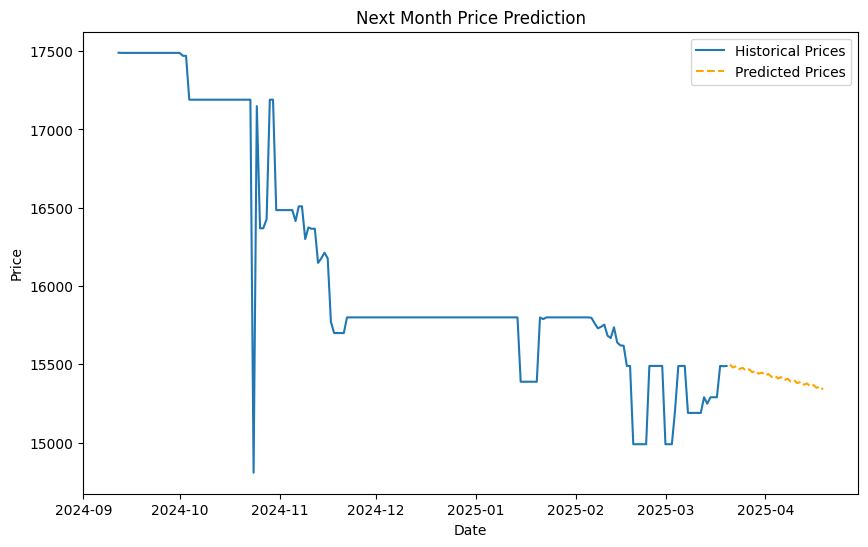

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the next month's prices
future_prices = []
current_features = price_history.iloc[-1][features].values  # Start with the latest features

for _ in range(30):  # Predict for the next 30 days
    # Convert current_features to a DataFrame with the same feature names
    current_features_df = pd.DataFrame([current_features], columns=features)
    
    # Predict the next price change
    next_price_change = model.predict(current_features_df)[0]
    
    # Adjust price (example: ±10)
    next_price = current_features[0] + (1 if next_price_change == 1 else -1) * 10
    future_prices.append(next_price)
    
    # Update features for the next prediction
    current_features = np.roll(current_features, -1)  # Shift features
    current_features[-1] = next_price  # Add the predicted price as the latest feature

# Generate dates for the next 30 days
future_dates = pd.date_range(price_history['timestamp'].iloc[-1] + pd.Timedelta(days=1), periods=30)

# Plot the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(price_history['timestamp'], price_history['price'], label='Historical Prices')
plt.plot(future_dates, future_prices, label='Predicted Prices', linestyle='--', color='orange')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Next Month Price Prediction')
plt.legend()
plt.show()